In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2025-08-12 23:31:25.524485: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 5

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125 (4.39 KB)

 Trainable params: 1,125 (4.39 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8060 - loss: 0.5358
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8021 - loss: 0.5460 - val_accuracy: 0.9334 - val_loss: 0.2779
Epoch 2/1000
16/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8021 - loss: 0.5014 
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8067 - loss: 0.5049 - val_accuracy: 0.9359 - val_loss: 0.2708
Epoch 3/1000
15/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8114 - loss: 0.4930 
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8045 - loss: 0.5207 - val_accuracy: 0.9383 - val_loss: 0.2660
Epoch 4/1000
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8094 - loss: 0.5025 
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.keras

In [13]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9334 - loss: 0.2789 


In [14]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
[2.2200793e-03 9.6328175e-01 3.3996835e-02 4.6221161e-04 3.9146795e-05]
1


# Confusion matrix

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


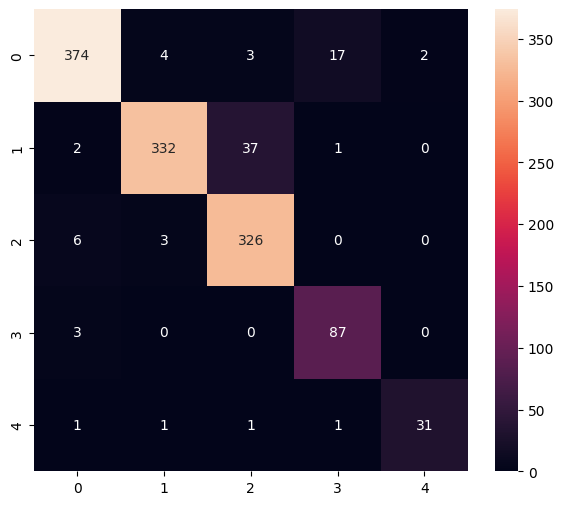

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       400
           1       0.98      0.89      0.93       372
           2       0.89      0.97      0.93       335
           3       0.82      0.97      0.89        90
           4       0.94      0.89      0.91        35

    accuracy                           0.93      1232
   macro avg       0.92      0.93      0.92      1232
weighted avg       0.94      0.93      0.93      1232



In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [19]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [20]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpgjqf7djs/assets


INFO:tensorflow:Assets written to: /tmp/tmpgjqf7djs/assets


Saved artifact at '/tmp/tmpgjqf7djs'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132080402217488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132080402218448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132080402213456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132080402218064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132080402215568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132080402214032: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1755063284.780698   43351 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1755063284.780723   43351 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-08-12 23:34:44.781262: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpgjqf7djs
2025-08-12 23:34:44.782255: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-08-12 23:34:44.782271: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpgjqf7djs
I0000 00:00:1755063284.789819   43351 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-08-12 23:34:44.791417: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-08-12 23:34:44.836137: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpgjqf7djs
2025-08-12 23:34:44.851070: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

6600

# Inference test

In [21]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

/home/malo/.local/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [22]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [23]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [24]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 1.25 ms, sys: 0 ns, total: 1.25 ms
Wall time: 999 μs


In [25]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.2200781e-03 9.6328175e-01 3.3996847e-02 4.6221161e-04 3.9146798e-05]
1
